We decided that it might be better to train the joint classifier only on labels that are present in all of the datasets. That is why we discarded Forum and Other from the train, dev and test split for X-GENRE. In this notebook, I will train the model again. The new model will be X-GENRE-2

Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
!pip install -q transformers

# Install the simpletransformers
!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [3]:
# Install wandb
!pip install -q wandb

import wandb

# Login to wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [6]:
# X-GENRE-2
train_df = pd.read_csv("/kaggle/input/xgenre2/X-GENRE-train.csv-2.csv", index_col=0)
dev_df = pd.read_csv("/kaggle/input/xgenre2/X-GENRE-dev.csv-2.csv",  index_col = 0)
test_df = pd.read_csv("/kaggle/input/xgenre2/X-GENRE-test.csv-2.csv", index_col = 0)

print("X-GENRE-2 train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

X-GENRE-2 train shape: (1562, 2), Dev shape: (522, 2), Test shape: (522, 2).


In [7]:
train_df.head()

,text,labels
2,Abstract Objective: Reporting bias due to soci...,Information/Explanation
3,In 2009 the song was the focus of a successful...,Information/Explanation
4,QuotW This was the week when neither rumours o...,News
5,KaZaA claims it can't stop users sharing music...,News
6,When you first sign up with an online casino a...,Instruction


In [8]:
# Merge the splits and display the label distribution
entire1 = pd.concat([train_df, dev_df])
joined_splits = pd.concat([entire1, test_df])

joined_splits.describe()

,text,labels
count,2606,2606
unique,2606,7
top,Abstract Objective: Reporting bias due to soci...,News
freq,1,573


In [9]:
print(joined_splits.labels.value_counts(normalize=True).to_markdown())

|                         |    labels |
|:------------------------|----------:|
| News                    | 0.219877  |
| Information/Explanation | 0.196086  |
| Promotion               | 0.183423  |
| Opinion/Argumentation   | 0.155027  |
| Instruction             | 0.134689  |
| Prose/Lyrical           | 0.0698388 |
| Legal                   | 0.0410591 |


## Training and saving

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [16]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
print(LABELS)

['Information/Explanation', 'News', 'Instruction', 'Opinion/Argumentation', 'Prose/Lyrical', 'Legal', 'Promotion']


In [12]:
# Initialize Wandb
wandb.init(project="X-GENRE classifiers", entity="tajak", name="X-GENRE-2-training")

wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


In [13]:
# Calculate how many steps will each epoch have
# Num steps in epoch = training samples / batch size
steps_per_epoch = int(1562/8)
steps_per_epoch

195

I evaluated per every 10th epoch - per 1950 steps. I first trained the model while evaluating it to find the optimal number of epochs and then trained it again and saved it.

In [ ]:
# Create a TransformerModel
roberta_base_model = ClassificationModel(
        "xlmroberta", "xlm-roberta-base",
        num_labels=len(LABELS),
        use_cuda=True,
        args= {
            "overwrite_output_dir": True,
            "num_train_epochs": 30,
            "train_batch_size":8,
            "learning_rate": 1e-5,
            # Use these parameters if you want to evaluate during training
            "evaluate_during_training": True,
            "evaluate_during_training_steps": steps_per_epoch*10,
            "evaluate_during_training_verbose": True,
            "use_cached_eval_features": True,
            'reprocess_input_data': True,
            "labels_list": LABELS,
            # The following parameters are commented out because I want to save the model
            "no_cache": True,
            # Disable no_save: True if you want to save the model
            "no_save": True,
            "max_seq_length": 512,
            "save_steps": -1,
            # Only the trained model will be saved - to prevent filling all of the space
            "save_model_every_epoch":False,
            "wandb_project": 'X-GENRE classifiers',
            "silent": True,
            }
        )

In [ ]:
# Train the model
roberta_base_model.train_model(train_df, eval_df = dev_df)

Based on evaluation during training, the optimum epoch is between 2 and 20 epochs.

In [18]:
def testing(test_df, test_name, epoch):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    - epoch: num_train_epochs
    """
    # Get the true labels
    y_true = test_df.labels

    model = roberta_base_model
    
    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    #fig1.savefig(f"Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": epoch,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.to_dict(),
        "y_pred": y_pred.to_dict(),
        }
    #previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Training loss,█▇▅▅▂▃▃▁▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_loss,█▂▁▂▂▂▃▅▄▄▅▅▆▆▆▇▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇██
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▂▄▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
mcc,▁▆▇▇█▇█▇█████████████████████████
train_loss,▆▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,0.00018
eval_loss,1.61964
global_step,5880
lr,0.0
mcc,0.76741


Macro f1: 0.749, Micro f1: 0.753


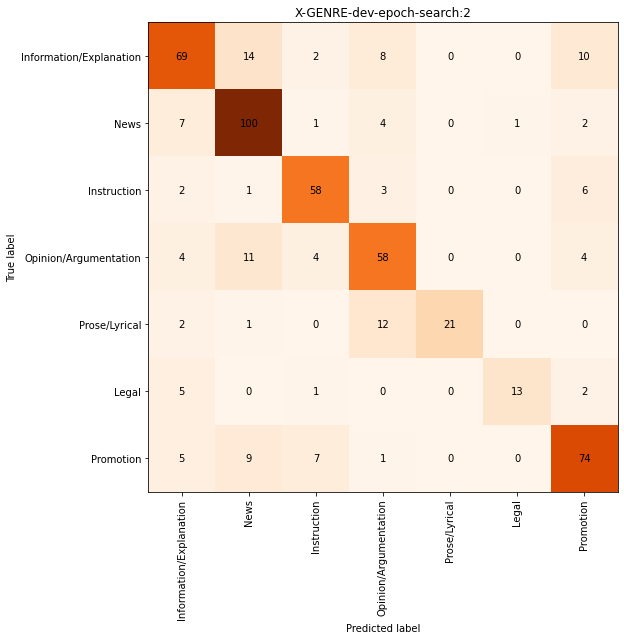

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Training loss,█▇▅▁▂▂▂
global_step,▁▂▃▅▆▇█
lr,█▇▆▅▃▂▁
Training loss,0.97588
global_step,350
lr,0.0


Macro f1: 0.811, Micro f1: 0.787


<Figure size 432x288 with 0 Axes>

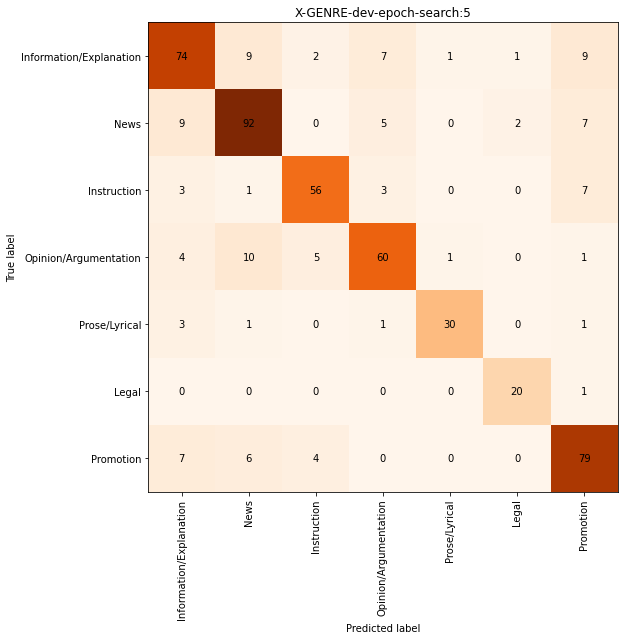

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Training loss,█▇▆▅▅▄▂▁▂▃▃▂▁▁▃▁▁▃▁
global_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
lr,▇██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
Training loss,0.15405
global_step,950
lr,0.0


Macro f1: 0.84, Micro f1: 0.82


<Figure size 432x288 with 0 Axes>

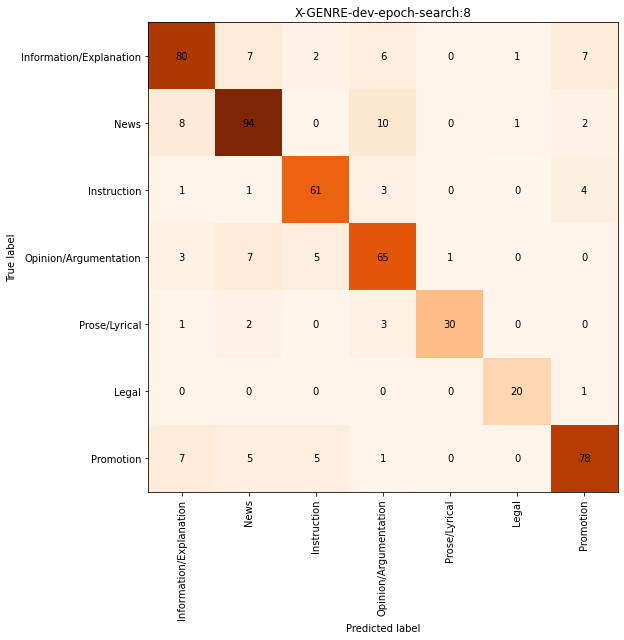

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Training loss,█▇▆▅▆▄▃▄▄▄▃▃▁▁▄▃▁▃▃▂▁▁▂▁▁▂▁▁▄▁▁
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▅███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.05662
global_step,1550
lr,0.0


Macro f1: 0.821, Micro f1: 0.807


<Figure size 432x288 with 0 Axes>

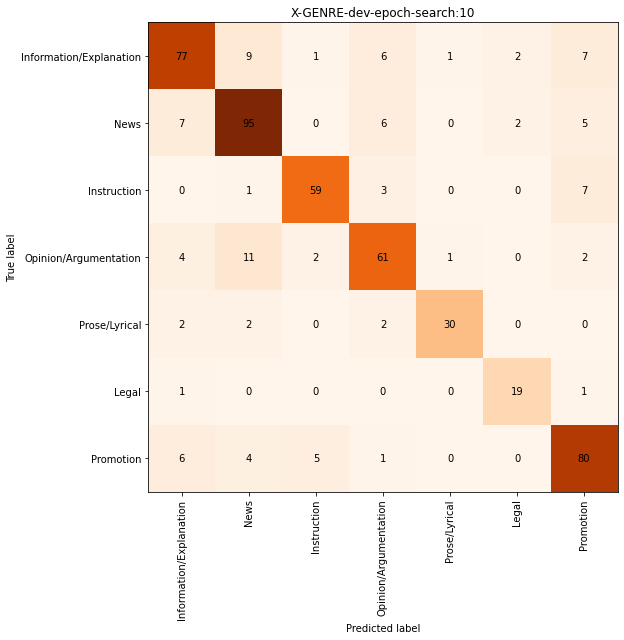

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Training loss,██▇▆▅▆▃▃▃▆▃▁▄▂▄▄▁▅▄▁▂▁▁▁▁▃▁▁▁▁▃▁▂▄▁▁▄▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▄▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00574
global_step,1950
lr,0.0


Macro f1: 0.811, Micro f1: 0.787


<Figure size 432x288 with 0 Axes>

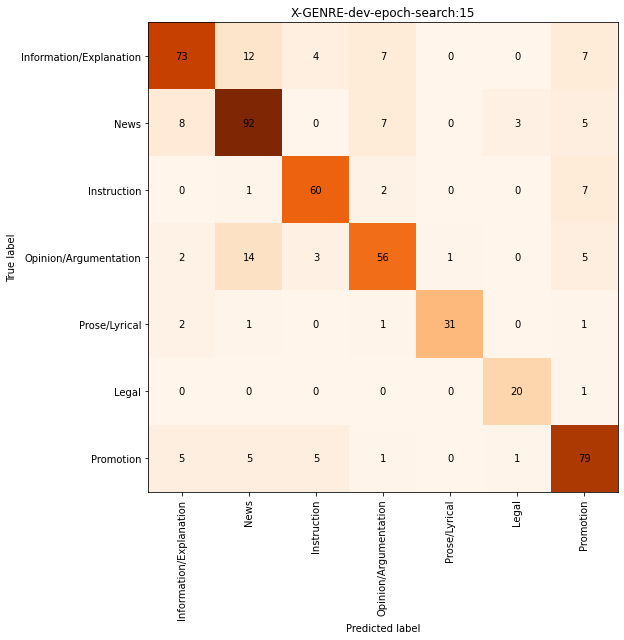

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Training loss,█▇█▆▅▅▂▆▄▃▃▃▂▁▁▄▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00157
global_step,2900
lr,0.0


In [ ]:
# Train the model for various epochs to find the optimum number
epochs = [2, 5, 8, 10, 15, 20]

for epoch in epochs:
    roberta_base_model = ClassificationModel(
                "xlmroberta", "xlm-roberta-base",
                num_labels=len(LABELS),
                use_cuda=True,
                args= {
                    "overwrite_output_dir": True,
                    "num_train_epochs": epoch,
                    "train_batch_size":8,
                    "learning_rate": 1e-5,
                    "labels_list": LABELS,
                    # The following parameters (no_cache, no_save) are commented out if I want to save the model
                    "no_cache": True,
                    # Disable no_save: True if you want to save the model
                    "no_save": True,
                    "max_seq_length": 512,
                    "save_steps": -1,
                    # Only the trained model will be saved - to prevent filling all of the space
                    "save_model_every_epoch":False,
                    "wandb_project": 'X-GENRE classifiers',
                    "silent": True,
                    }
                )

    # Train the model
    roberta_base_model.train_model(train_df)
    
    # Test the model on dev_df
    testing(dev_df, f"X-GENRE-dev-epoch-search:{epoch}", epoch)

Optimum number of epochs was shown to be 8.

In [ ]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

In [ ]:
# Save the file with updated results.
with open("FTD-X-GENRE-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

In [14]:
# Create a TransformerModel
roberta_base_model = ClassificationModel(
        "xlmroberta", "xlm-roberta-base",
        num_labels=len(LABELS),
        use_cuda=True,
        args= {
            "overwrite_output_dir": True,
            "num_train_epochs": 8,
            "train_batch_size":8,
            "learning_rate": 1e-5,
            "labels_list": LABELS,
            # The following parameters are commented out because I want to save the model
            #"no_cache": True,
            # Disable no_save: True if you want to save the model
            #"no_save": True,
            "max_seq_length": 512,
            "save_steps": -1,
            # Only the trained model will be saved - to prevent filling all of the space
            "save_model_every_epoch":False,
            "wandb_project": 'X-GENRE classifiers',
            "silent": True,
            }
        )

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:487: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [15]:
# Train the model
roberta_base_model.train_model(train_df)

(1568, 0.5677626069102969)

In [18]:
%ls /kaggle/working/outputs

config.json        sentencepiece.bpe.model  tokenizer_config.json
model_args.json    special_tokens_map.json  training_args.bin
pytorch_model.bin  tokenizer.json


In [ ]:
# Save the trained model to Wandb
run = wandb.init(project="X-GENRE classifiers", entity="tajak", name="saving-trained-model")
trained_model_artifact = wandb.Artifact("X-GENRE-2-classifier", type="model", description="a model trained on the X-GENRE dataset from which I discarded labels 'Forum' and 'Other'. List of labels: ['Information/Explanation', 'News', 'Instruction', 'Opinion/Argumentation', 'Prose/Lyrical', 'Legal', 'Promotion']")
trained_model_artifact.add_dir("/kaggle/working/outputs")
run.log_artifact(trained_model_artifact)

Training loss,▇█▆▅▅▃▄▃▂▃▃▂▂▂▄▃▁▁▁▁▁▁▂▁▃▁▃▁▂▃▄
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▅███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.71594
global_step,1550
lr,0.0
